In [15]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
directory = './data/ffs/preprocessed/DP1_718,18181818181733-0,43636363636363645-0,10181818181818182/'
mesh_tensor = torch.load(directory + 'mesh_points.th', weights_only=True)

In [28]:
from data.ffs.csv_rw import csv_to_dict

# define csv parameters
csvInvarNames = ["Points:0", "Points:1"]
dictInvarNames = ["x", "y"]
# csvOutvarNames = ["Velocity:0", "Velocity:1", "Pressure"]
# dictOutvarNames = ["u", "v", "p"]
scales = {"x": (0,1), "y": (-0.5,1)} #(translation, scale)
skiprows = 0
csvVarNames = csvInvarNames
dictVarNames = dictInvarNames

mapping = {}
for csvVarName, dictVarName in zip(csvVarNames, dictVarNames):
    mapping[csvVarName] = dictVarName


#read and process csv
csvData = csv_to_dict('./data/ffs/bound/DP1_bound.csv', mapping=mapping, delimiter=",", skiprows=skiprows)
for key in dictVarNames:
    csvData[key] += scales[key][0]
    csvData[key] /= scales[key][1]

In [8]:
csvData

{'x': array([[ 5.3305],
        [ 5.2804],
        [ 5.3807],
        ...,
        [-5.0012],
        [-5.0512],
        [-5.1013]]),
 'y': array([[-0.5],
        [-0.5],
        [-0.5],
        ...,
        [-0.5],
        [-0.5],
        [-0.5]])}

In [29]:
boundary_points = np.array([csvData["x"], csvData["y"]]).T[0]
# boundary_tensor = torch.from_numpy(boundary_points)
# torch.save(boundary_tensor, "boundary_tensor.th")

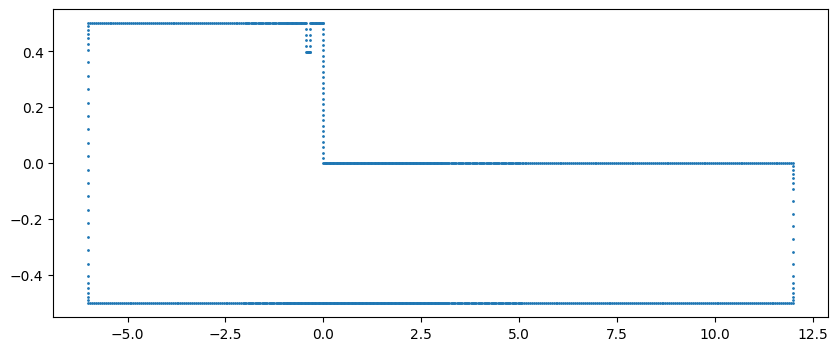

In [30]:
# Visualize
plt.figure(figsize=(10, 4))
plt.scatter(boundary_points[:, 0], boundary_points[:, 1], s=1)
# plt.colorbar(label="Signed Distance")
# plt.axis("equal")
# plt.title("SDF values colored on point cloud")
plt.show()

In [33]:
import networkx as nx
def order_points_tsp(points):
    G = nx.complete_graph(len(points))
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            dist = np.linalg.norm(points[i] - points[j])
            G[i][j]["weight"] = dist
            G[j][i]["weight"] = dist
    tsp_path = nx.approximation.traveling_salesman_problem(G, cycle=True)
    ordered_points = points[tsp_path]
    return ordered_points

# Apply ordering
ordered = order_points_tsp(boundary_points)

In [53]:
import numpy as np
from shapely.geometry import Point, Polygon, LineString

# Define the outline shape (e.g., a step as a polygon)
boundary = LineString(ordered)


def signed_distance(p, shape):
    point = Point(p)
    distance = point.distance(shape)
    # Negative if inside the shape
    if shape.contains(point):
        return -distance/0.5
    else:
        return distance/0.5

# Compute signed distances
sdf_values = np.array([signed_distance(p, boundary) for p in mesh_tensor])

In [54]:
sdf_values.max()

np.float64(0.999920000002021)

(<matplotlib.patches.PathPatch at 0x760f9cfc2890>,
 <matplotlib.lines.Line2D at 0x760f9cdb7dd0>)

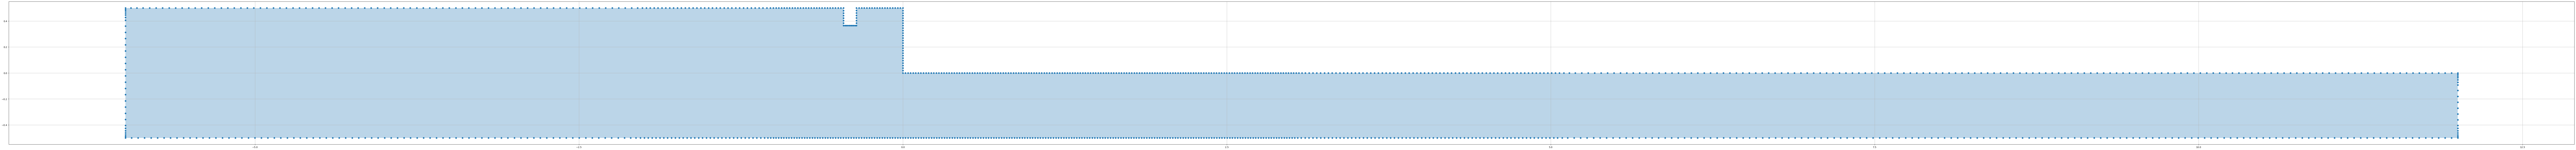

In [ ]:
from shapely.plotting import plot_polygon
plt.figure(figsize=(200, 80))
plot_polygon(boundary, linewidth=0.01)

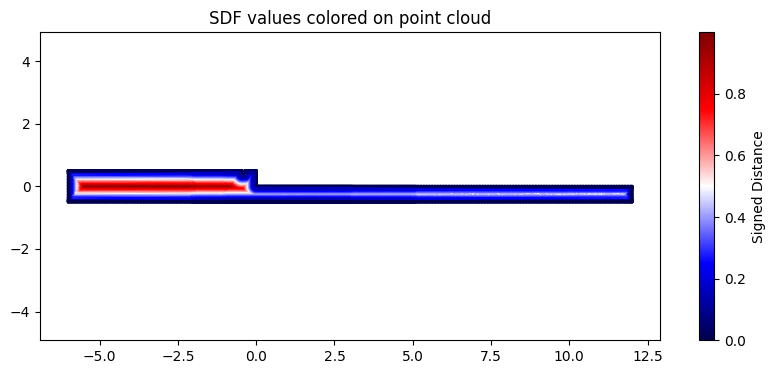

In [55]:
# Visualize
plt.figure(figsize=(10, 4))
plt.scatter(mesh_tensor[:, 0], mesh_tensor[:, 1], c=sdf_values, cmap="seismic", s=1)
plt.colorbar(label="Signed Distance")
plt.axis("equal")
plt.title("SDF values colored on point cloud")
plt.show()

In [4]:
# Load tensor data
directory = './data/ffs/preprocessed/DP10_463,63636363636368-0,45818181818181825-0,13454545454545455/'
mesh_tensor = torch.load(directory + 'mesh_points.th')
sdf_tensor = torch.load(directory + 'mesh_sdf.th')
p_tensor = torch.load(directory + 'p.th')
u_tensor = torch.load(directory + 'u.th')
v_tensor = torch.load(directory + 'v.th')

# Add data to dict
dataDict = {
    'mesh': mesh_tensor,
    'sdf': sdf_tensor,
    'p': p_tensor,
    'u': u_tensor,
    'v': v_tensor,
    # 'sdf_res32': sdf_res32_tensor 
}

/tmp/ipykernel_1541916/3871987313.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mesh_tensor = torch.load(directory + 'mesh_points.th')
/tmp/ipykernel_1541916/387198731

In [1]:
from upt.datasets.ffs_dataset import ffsDataset

num_test_inputs  = 8192
num_test_outputs = 8192
# num_train_inputs  = 8192
# num_train_outputs = 16000

num_train_inputs  = num_test_inputs 
num_train_outputs = num_test_outputs

crop_values= [[-3, -2], [3, 2]]

# initialize dataset
train_dataset = ffsDataset(
    root="./data/ffs/preprocessed",
    # how many inputs to use for training
    # num_inputs=float("inf"),
    num_inputs=num_train_inputs,
    # how many outputs to use for training
    # num_outputs=float("inf"),
    num_outputs=num_train_outputs,
    # mode
    mode="train",
    # crop
    crop_values= crop_values,
)

[PosixPath('data/ffs/preprocessed/DP100_699,9999999999992-0,93818181818181645-0,46181818181818091'), PosixPath('data/ffs/preprocessed/DP10_463,63636363636368-0,45818181818181825-0,13454545454545455'), PosixPath('data/ffs/preprocessed/DP11_563,63636363636363-0,989090909090907-0,13818181818181818'), PosixPath('data/ffs/preprocessed/DP12_336,36363636363637-0,99636363636363523-0,14181818181818184'), PosixPath('data/ffs/preprocessed/DP13_372,72727272727275-0,69090909090909047-0,14545454545454548'), PosixPath('data/ffs/preprocessed/DP14_754,54545454545348-0,59636363636363643-0,14909090909090911'), PosixPath('data/ffs/preprocessed/DP15_263,63636363636368-0,27636363636363637-0,15272727272727274'), PosixPath('data/ffs/preprocessed/DP16_72,72727272727272-0,84363636363636241-0,15636363636363637'), PosixPath('data/ffs/preprocessed/DP17_200,00000000000003-0,2181818181818182-0,16000000000000003'), PosixPath('data/ffs/preprocessed/DP18_709,09090909090833-0,87272727272727124-0,16363636363636364'), Pos

In [ ]:
from torch.utils.data import DataLoader
from upt.collators.ffs_collator import ffsCollator

testvis_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=100,
    collate_fn=ffsCollator(num_supernodes=2048, deterministic=True),
)
data = [d for d in iter(testvis_dataloader)]

In [6]:
for i in range(len(data)):
    sample = data[i]
    name = sample["name"]
    print(name)

['DP100_699,9999999999992-0,93818181818181645-0,46181818181818091', 'DP10_463,63636363636368-0,45818181818181825-0,13454545454545455', 'DP11_563,63636363636363-0,989090909090907-0,13818181818181818', 'DP12_336,36363636363637-0,99636363636363523-0,14181818181818184', 'DP13_372,72727272727275-0,69090909090909047-0,14545454545454548', 'DP14_754,54545454545348-0,59636363636363643-0,14909090909090911', 'DP15_263,63636363636368-0,27636363636363637-0,15272727272727274', 'DP16_72,72727272727272-0,84363636363636241-0,15636363636363637', 'DP17_200,00000000000003-0,2181818181818182-0,16000000000000003', 'DP18_709,09090909090833-0,87272727272727124-0,16363636363636364', 'DP19_845,4545454545439-0,40727272727272734-0,1672727272727273', 'DP1_718,18181818181733-0,43636363636363645-0,10181818181818182', 'DP20_109,09090909090909-0,20363636363636364-0,17090909090909093', 'DP21_436,36363636363649-0,3636363636363637-0,17454545454545456', 'DP22_599,99999999999977-0,53818181818181832-0,17818181818181822', 'D

In [ ]:
for i in range(5):
    sample = train_dataset[i]
    # plot sparse
    x_pos, y_pos = train_dataset.denormalize_pos(sample["output_pos"]).unbind(1)
    target = train_dataset.denormalize_feat(sample["target_feat"]).clamp(0, 1)
    target = target[:,0]

    plt.figure(figsize=(10, 2))
    plt.title(sample["name"])
    plt.scatter(x_pos, y_pos, c=target, marker="s", s=1)
    plt.show()

In [5]:
# Load tensor data
directory = '../data/ffs/preprocessed/'
coords_norm = torch.load(directory + 'coords_norm.th')
vars_norm = torch.load(directory + 'vars_norm.th')

/tmp/ipykernel_373902/1446659531.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coords_norm = torch.load(directory + 'coords_norm.th')
/tmp/ipykernel_373902/1446659531.

In [ ]:
#Save to matlab format
import scipy.io as sio

saveDir = './data/ffs/mat/'


sio.savemat(saveDir + directory.split('/')[-2] + '.mat', dataDict)

In [34]:
for i in range(100):
    print('DP ' + str(i+1))

DP 1
DP 2
DP 3
DP 4
DP 5
DP 6
DP 7
DP 8
DP 9
DP 10
DP 11
DP 12
DP 13
DP 14
DP 15
DP 16
DP 17
DP 18
DP 19
DP 20
DP 21
DP 22
DP 23
DP 24
DP 25
DP 26
DP 27
DP 28
DP 29
DP 30
DP 31
DP 32
DP 33
DP 34
DP 35
DP 36
DP 37
DP 38
DP 39
DP 40
DP 41
DP 42
DP 43
DP 44
DP 45
DP 46
DP 47
DP 48
DP 49
DP 50
DP 51
DP 52
DP 53
DP 54
DP 55
DP 56
DP 57
DP 58
DP 59
DP 60
DP 61
DP 62
DP 63
DP 64
DP 65
DP 66
DP 67
DP 68
DP 69
DP 70
DP 71
DP 72
DP 73
DP 74
DP 75
DP 76
DP 77
DP 78
DP 79
DP 80
DP 81
DP 82
DP 83
DP 84
DP 85
DP 86
DP 87
DP 88
DP 89
DP 90
DP 91
DP 92
DP 93
DP 94
DP 95
DP 96
DP 97
DP 98
DP 99
DP 100
